# Inf2 - Foundations of Data Science
## Week 09: K-Means

**Learning outcomes:** 
In this lab you will implement the K-Means algorithm from scratch.

By the end of the lab you should be able to:
- implement and explain the different steps involved in K-Means,
- explain what the benefits of clustering algorithms are,
- explain what partitional clustering algorithms are,
- and be able to use sklearn's K-Means algorithm.

**Research question:**

In this lab we will use K-means on the same breast cancer patients data to see how many types of cancer can be distinguished.

**Data set information:** 

The data set is adapted from [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). It contains patient information taken from patients with breast cancer. 

In [232]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
#Importing sklearn functions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans

Clustering refers to a group of unsupervised learning algorithms, one of which is K-means. Each cluster is a group of data points in which points should be more similar to each other than they are to points in other clusters. Clustering is used to interpret and compress data. Interpretation can help to deepen our knowledge of the dataset. For example in medicine, we might be interested in particular clusters of symptoms of a disease. For example, researchers at King's College have identified six clusters of patterns of [Coronavirus symptoms over time](https://www.medrxiv.org/content/10.1101/2020.06.12.20129056v1.full.pdf). The cluster labels can then be used as independent variables with hospitalisation as dependent variable to build a model predicting the likelihood of hospitalisation given a cluster membership.

K-Means belongs to the group of *partitional clustering* algorithms, in which we partition the data into $K$ non-overlapping clusters; each data point can only belong to exactly one cluster. If you are interested in other clustering algorithms, such as *hierarchical* or *density based* clustering, we invite you to read the following [paper](https://link.springer.com/content/pdf/10.1007/s40745-015-0040-1.pdf), or take IAML in your honours years.

Partitional clustering algorithms are non-deterministic, which means that each run can lead to different clusters even on the same data set. The main benefits of partitional clustering algorithms are their simplicity and low computational complexity. However, they are also only well suited for spherical clusters and do not cope well with complex shapes. 

The following pseudo code should help you remember from the lecture how the algorithm works:  

In [233]:
# Choose k centroids randomly
# While(centroids are not the same as in the previous iteration) do:
    # Assign each data point to its closest centroid
    # Compute new centroid based on the mean of all the points in the cluster
# end while

## 9.A Implementing K-Means

The first step is to initialize the centroids. The easiest way would be to just take the first `K` data points. However, we also know that the result of K-Means depends on the initial centroids, and thus a random assignment is beneficial to allow for more restarts.

**Exercise 01:** 
- Create a function `initialize_centroids()`. It should take as parameters `data`, a numpy 2-dimensional array in which each row is an instance ($\mathbf x_i$ in the lecture notes) and `n_clusters` the number of clusters we are looking for ($K$ in the lecture notes). (Remark: we use `n_clusters` instead of `k_clusters`, as this is the notation used in sklearn and it won't confuse you once you use the sklearn functions.)
- Create an array `random_data_points` with `n_clusters` random integers in the range from 0 to the length of the data set. 

Hint: You can either create a loop which gets a [random number](https://pynative.com/python-random-randrange/) between 0 and the length of the data set, and appends the value to the `random_data_points` array (remember that each value appended to the array needs to be distinct), or you can use [numpy's](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.permutation.html) `random.permutation` function to create an array of same length as the data set with randomly permutated integers between 0 and length of the data set, and take the first `n_clusters` values of that array and assign it to `random_data_points`. 

- Finally, create a new numpy array by filtering from the data sets the rows corresponding to the randomly chosen numbers. and return it.

In [234]:
# Your code
def initialize_centroids(data, n_clusters):
    length = len(data)
    random_data_points = [np.random.randint(0, length) for i in range(n_clusters)]
    random_select = np.array(data[random_data_points])
    return random_select

The next step consists of assigning each data point to a cluster.

**Exercise 02:**
- Create a function `assign_clusters()`. It should take as parameters `data` and `centroids`.
- Use `pairwise_distance(data, centroids, metric='euclidean')` from the sklearn library (which we have imported above) to compute the distance of each data point to each of the centroids. Look up the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html) to understand how the function works, and what the return value is. Store the returned value in a new variable `euclidean_distance`.
- Find the centroid that is closest to each data point, and store the array with the numbers representing the centroids for each data point in an array `assigned_clusters`. Hint: numpy's `argmin()` might help to find the centroid with the minimal distance. 
- Return `assigned_clusters`.

In [235]:
# Your code
def assign_clusters(data, centroids):
    euclidean_distance = pairwise_distances(data, centroids, metric='euclidean')
    assigened_clusters = np.argmin(euclidean_distance, axis=1)
    return assigened_clusters

The last step to compute the optimal centroids is to update the centroids, based on their assignment of the previous iteration.

**Exercise 03:**
- Create a function `update_centroids()`. It should take as parameters `data`, `n_clusters` and `assigned_clusters`.
- For each cluster, compute the mean for each feature of all the data points in the cluster. You can use a loop or a list comprehension, and remember the numpy mean() function - but make sure you get the `axis` argument right.
- Create a 2-dimensional array `centroids` such that each row in the matrix contains the list of means computed for each cluster.
- Return the `centroids` as a 2-dimensional array, with each row containing one centroid.

Hint: The type of the final returned value should be a ndarray.

In [236]:
# Your code
def update_centroids(data, n_clusters, assigned_clusters):
    centroids = [np.zeros(len(data[0]))] * n_clusters
    count = [0] * n_clusters
    for i, n in enumerate(assigned_clusters):
        count[n] += 1
        centroids[n] = centroids[n] + data[i]
    centroids = [centroids[i] / count[i] for i in range(n_clusters)]
    return np.array(centroids)

Now we have all the auxiliary functions that we need to finish to write our K-means algorithm. We are going to structure the code in a similar way to sklearn.

**Remark:** For every model sklearn implements there is a class with  `fit()` and `predict()` methods. The `fit()` method trains the model and the `predict()` method allows us to determine the classification of a seen or unseen data point. The term "predict" is perhaps a bit misleading in the case of K-means, where `.predict()` means "determine the cluster of a data point".

**Exercise 04:**
We have prepared a skeleton for a class called `K_Means`. We have also already prepared the constructor. Your job is now to add two methods: `fit()` and `predict()`.
- For the `fit()` method, look at the pseudo code above, and use the three functions you have coded previously to fit the model. Store the final centroids to `self.centroids`.
- The `predict()` method should take only one observation as input and compute to which centroid the distance is minimal, and then return the value of the centroid. (Careful: It will probably return an array with just one entry, but it should just return an integer.) 

In [237]:
# Choose k centroids randomly
# While(centroids are not the same as in the previous iteration) do:
    # Assign each data point to its closest centroid
    # Compute new centroid based on the mean of all the points in the cluster
# end while
def compare(prev, curr):
    res = True
    for i in range(len(prev)):
        for j in range(len(prev[i])):
            res = res and prev[i][j] == curr[i][j]
    return res

class K_Means:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.centroids = None
        self.max_iter = max_iter
        
    def fit(self, data):
        prev = None
        curr = initialize_centroids(data, self.n_clusters)
        iter_ = 0
        while prev is None or not compare(prev, curr) or iter_ < self.max_iter:
            prev = curr
            assigned_clusters = assign_clusters(data, curr)
            curr = update_centroids(data, self.n_clusters, assigned_clusters)
            iter_ += 1
        self.centroids = curr
        
    def predict(self, observation):
        observation = np.array([observation])
        result = assign_clusters(observation, self.centroids)
        return self.centroids[result]
    
    
        
        
# Your code        


**Discussion:** Before we apply the K-means algorithm, it is a good idea to standardize your data. Try to remember with your lab partner why standardization is important.

Your answer:

## 9.B Applying K-Means

We are given a data set of breast cancer patients. Our aim is to see if we can cluster the breast cancer data into two categories.

**Exercise 05:** 
- Load the `breast_cancer.csv` data set from `datasets`. We have preprocessed the data set for you. All unnecessary columns and rows with NaN values have been removed.
- We need to standardize the `breast_cancer` data. We can either
  - use the standardize() from the last lab or 
  - use the sklearn `StandardScaler()` class. Here is the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
- Display your standardized data sets.

In [238]:
# Your code
datasets = pd.read_csv('datasets/breast_cancer.csv')
scaler = StandardScaler()
scaler.fit(datasets)
datasets = scaler.transform(datasets)

Let us now run our K-means algorithm on our data set.

**Exercise 06:**
- Instantiate a `K_Means` object with `n_clusters=2` parameters.
- Fit the model with your standardized data set.
- Print the centroids.
- Use [sklearn's native K-Means class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to compute the centroids, and print them out. Do you get similar results?

In [239]:
# Your code
self_fit = K_Means()
self_fit.fit(datasets)
print("Self fit:")
print(self_fit.centroids)
model_fit = KMeans(n_clusters=2).fit(datasets)
print("Model fit:")
print(model_fit.cluster_centers_)

Self fit:
[[ 0.06745285  0.93362406  0.4620646   0.96730462  0.92424266  0.60116657
   1.01678879  1.11927003  1.13499581  0.59745592  0.28828783  0.82729086
   0.0408053   0.83306382  0.77658149  0.0460656   0.71559384  0.64677371
   0.76877382  0.14483925  0.45777508  1.00100618  0.48610441  1.02895252
   0.96525332  0.61097579  0.95149718  1.0377126   1.12132923  0.58638203
   0.65089347]
 [-0.03489561 -0.48299485 -0.23904142 -0.50041892 -0.47814154 -0.3110035
  -0.52601873 -0.57903569 -0.58717117 -0.30908386 -0.1491409  -0.42798514
  -0.02110994 -0.43097168 -0.40175149 -0.02383127 -0.37020054 -0.3345976
  -0.39771232 -0.07493017 -0.23682231 -0.51785387 -0.25147802 -0.53231144
  -0.49935772 -0.31607814 -0.49224121 -0.53684332 -0.58010099 -0.30335497
  -0.33672889]]
Model fit:
[[ 0.07548132  0.97397614  0.48151381  1.0066346   0.96352718  0.60925407
   1.020696    1.13942935  1.16458212  0.61113855  0.25222982  0.85859633
   0.04274078  0.86027888  0.8071077   0.01706063  0.69505052 

**Remark:** If you run the code several times, you might get a slightly different result every time.

**Exercise 07:**

In some cases, if the data set is very large the optimization can take a very long time. Add an object variable to your object called `max_iter` in the object constructor with a default value 100. Add an extra iteration variable to your loop and a condition to the loop that breaks the loop once the iterator is greater than `max_iter`.

In [240]:
# Your code
self_fit = K_Means()
self_fit.fit(datasets)
print("Self fit:")
print(self_fit.centroids)
model_fit = KMeans(n_clusters=2).fit(datasets)
print("Model fit:")
print(model_fit.cluster_centers_)

Self fit:
[[ 0.07548132  0.97397614  0.48151381  1.0066346   0.96352718  0.60925407
   1.020696    1.13942935  1.16458212  0.61113855  0.25222982  0.85859633
   0.04274078  0.86027888  0.8071077   0.01706063  0.69505052  0.63689512
   0.77623856  0.14038222  0.41503212  1.04008365  0.50631048  1.06597067
   1.00315418  0.60829274  0.95083725  1.04429844  1.14621103  0.59741617
   0.62246932]
 [-0.03754203 -0.48442497 -0.23948977 -0.50066826 -0.47922799 -0.30302374
  -0.50766196 -0.56671617 -0.57922637 -0.30396101 -0.12545115 -0.4270387
  -0.02125791 -0.42787555 -0.40142988 -0.00848542 -0.34569618 -0.31677152
  -0.38607654 -0.06982168 -0.20642387 -0.51730476 -0.25182285 -0.53018015
  -0.49893721 -0.3025456  -0.47291642 -0.51940106 -0.57008917 -0.29713594
  -0.30959659]]
Model fit:
[[-0.03754203 -0.48442497 -0.23948977 -0.50066826 -0.47922799 -0.30302374
  -0.50766196 -0.56671617 -0.57922637 -0.30396101 -0.12545115 -0.4270387
  -0.02125791 -0.42787555 -0.40142988 -0.00848542 -0.34569618 

**Exercise 08:**

Finally, we would like to plot the centroids. However, our data is high-dimensional. By now you should think "Too many dimensions? -> PCA".

- Apply PCA to your standardized dataset - we suggest you use 3 components, but you may wish to look at how much variance is explained by each component using `pca.explained_variance_ratio_`
- Apply K-means to the PCA scores, using `max_iter = 5`. (Run it several times to see whether the centroids remain the same.)
- Plot the scatter plot of the first two dimensions, colouring the two clusters differently.
- Plot the two centroids with different markers.
- Repeat the exercise with `max_iter=100`. (Run it several times to see, whether this time the centroids have converged.) 

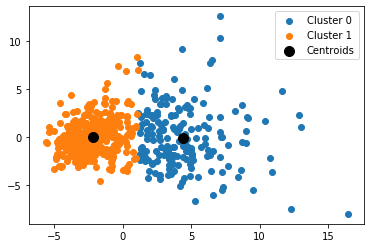

In [249]:
# Your code
pca = PCA(n_components=3).fit(datasets)
pca_dataset = pca.transform(datasets)
pca_model = KMeans(n_clusters=2, max_iter=5).fit(pca_dataset)
pca_assigned_clusters = pca_model.predict(pca_dataset)
# Data points
pca_data = pd.DataFrame(pca_dataset)
pca_data.columns = ['pc1', 'pc2', 'pc3']
pca_data['cluster'] = pca_assigned_clusters
plt.scatter(pca_data[pca_data.cluster == 0]['pc1'], pca_data[pca_data.cluster == 0]['pc2'], label='Cluster 0')
plt.scatter(pca_data[pca_data.cluster == 1]['pc1'], pca_data[pca_data.cluster == 1]['pc2'], label='Cluster 1')
# cluster centers
pca_clusters = pd.DataFrame(pca_model.cluster_centers_)
pca_clusters.columns = ['pc1', 'pc2', 'pc3']
pca_clusters['no'] = [0,1]
plt.scatter(pca_clusters['pc1'], pca_clusters['pc2'], s=100, c='black', label='Centroids')
plt.legend()

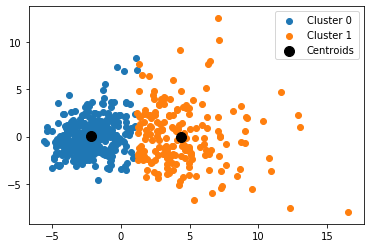

In [250]:
# Your code (for max_iter=100)
pca = PCA(n_components=3).fit(datasets)
pca_dataset = pca.transform(datasets)
pca_model = KMeans(n_clusters=2, max_iter=100).fit(pca_dataset)
pca_assigned_clusters = pca_model.predict(pca_dataset)
# Data points
pca_data = pd.DataFrame(pca_dataset)
pca_data.columns = ['pc1', 'pc2', 'pc3']
pca_data['cluster'] = pca_assigned_clusters
plt.scatter(pca_data[pca_data.cluster == 0]['pc1'], pca_data[pca_data.cluster == 0]['pc2'], label='Cluster 0')
plt.scatter(pca_data[pca_data.cluster == 1]['pc1'], pca_data[pca_data.cluster == 1]['pc2'], label='Cluster 1')
# cluster centers
pca_clusters = pd.DataFrame(pca_model.cluster_centers_)
pca_clusters.columns = ['pc1', 'pc2', 'pc3']
pca_clusters['no'] = [0,1]
plt.scatter(pca_clusters['pc1'], pca_clusters['pc2'], s=100, c='black', label='Centroids')
plt.legend()

It looks like there are two reasonably well-separated clusters. Let's compare how well they match the benign and malignant clusters from the dataset from our previous lab.

**Exercise 09:**

- Load the `breast_cancer_diagnosis.csv` dataset, which in addition to the previous dimensions, contains the diagnosis `M` (malignant) or `B` (benign).
- Plot the scatter plot of the first two dimensions of the pca scores from the last exercise, but this time colouring the benign and malignant classes differently.

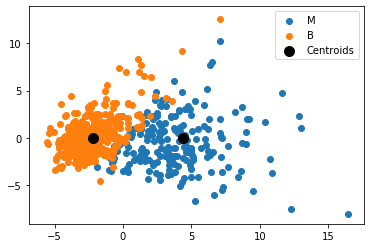

In [254]:
# Your code
bc_diagnosis = pd.read_csv('datasets/breast_cancer_diagnosis.csv')
pca = PCA(n_components=3).fit(datasets)
pca_dataset = pca.transform(datasets)
pca_model = KMeans(n_clusters=2, max_iter=100).fit(pca_dataset)
pca_assigned_clusters = pca_model.predict(pca_dataset)
# Data points
pca_data = pd.DataFrame(pca_dataset)
pca_data.columns = ['pc1', 'pc2', 'pc3']
pca_data['outcome'] = bc_diagnosis['diagnosis']
plt.scatter(pca_data[pca_data.outcome == 'M']['pc1'], pca_data[pca_data.outcome == 'M']['pc2'], label='M')
plt.scatter(pca_data[pca_data.outcome == 'B']['pc1'], pca_data[pca_data.outcome == 'B']['pc2'], label='B')
# cluster centers
pca_clusters = pd.DataFrame(pca_model.cluster_centers_)
pca_clusters.columns = ['pc1', 'pc2', 'pc3']
pca_clusters['no'] = [0,1]
plt.scatter(pca_clusters['pc1'], pca_clusters['pc2'], s=100, c='black', label='Centroids')
plt.legend()

**Exercise 10:**
- Count the numbers of benign and malignant patients in each cluster.
- Which cluster best corresponds to each diagnosis?

In [257]:
# Your code
cluster0_M = 0
cluster0_B = 0
cluster1_M = 0
cluster1_B = 0
for i,diag in zip(pca_assigned_clusters, bc_diagnosis['diagnosis']):
    if i == 0:
        if diag == 'M':
            cluster0_M += 1
        else:
            cluster0_B += 1
    else:
        if diag == 'M':
            cluster1_M += 1
        else:
            cluster1_B += 1
print("Cluster 0 benign:", cluster0_M)
print("Cluster 0 malignant:", cluster0_B)
print("Cluster 1 benign:", cluster1_M)
print("Cluster 1 malignant:", cluster1_B)

Cluster 0 benign: 175
Cluster 0 malignant: 14
Cluster 1 benign: 37
Cluster 1 malignant: 343


**Discussion:**

You have learned a lot in the last few labs:

- Cleaning your data.
- Plotting your data.
- Applying PCA and K-Means.

And you have used all those skills in this lab. However, there are a couple of things you should think about. Discuss the following points with your lab partner.

- How could you prevent your model from overfitting to the data?
- We have already discussed `max_iter` as one option to stop the optimization if it takes too long. What is a different criterion based on which we could stop the optimization?

*Hint:* Look at the sklearn documentation of K-Means, the parameters might give you some ideas.

Your answer:

**We need your help:** This is a new course. In order for us to improve the labs for the next iterations, and to make sure that the next labs are better, we need your feedback. Please fill out the following [form](https://forms.office.com/Pages/ResponsePage.aspx?id=sAafLmkWiUWHiRCgaTTcYZmGMCx4KxlMjSTITqjdcXpUMTNCSlU4SzhaTVAyMjJGVlRWSUtaM1ZLQi4u).